# Model Interpretation & Validation - Injury Risk Predictor

This notebook interprets the trained model and validates it against sports science research.

## Steps:
1. Load trained model and data
2. Feature importance analysis
3. SHAP values for explainability
4. Partial dependence plots
5. Error analysis
6. Validation against research
7. Cross-validation

In [1]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.ml.features import engineer_features_for_dataset
from src.ml.preprocessing import (
    handle_missing_values,
    encode_categorical_features,
    split_data_by_time,
    scale_features
)
from src.ml.train import load_model, load_scaler
from src.ml.interpretation import (
    plot_feature_importance,
    calculate_shap_values,
    plot_shap_summary,
    plot_partial_dependence,
    analyze_errors,
    validate_against_research,
    print_validation_report
)

## 1. Load Model and Data

In [2]:
# Load data
training_logs = pd.read_csv('../data/training_logs.csv')

# Engineer features
df = engineer_features_for_dataset(training_logs)
df = handle_missing_values(df, method='forward_fill')
df, encoders = encode_categorical_features(df)

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data_by_time(
    df,
    train_weeks=(1, 14),
    val_weeks=(15, 19),
    test_weeks=(20, 24)
)

# Try to load scaler and model
scaler = None
model = None
model_name = None

try:
    scaler = load_scaler('../models')
    print("✓ Loaded scaler")
except FileNotFoundError:
    print("⚠ No scaler found. Training a new scaler...")
    # Train a new scaler if not found
    X_train_scaled, scaler = scale_features(X_train, fit=True, scaler_type='standard')
    X_val_scaled, _ = scale_features(X_val, fit=False, scaler=scaler)
    X_test_scaled, _ = scale_features(X_test, fit=False, scaler=scaler)
    print("✓ Created new scaler")
else:
    # Scale features with loaded scaler
    X_train_scaled, _ = scale_features(X_train, fit=False, scaler=scaler)
    X_val_scaled, _ = scale_features(X_val, fit=False, scaler=scaler)
    X_test_scaled, _ = scale_features(X_test, fit=False, scaler=scaler)

# Load best model (adjust name based on what was saved)
# Try common model names (with different naming conventions)
model_names = ['random_forest', 'Random Forest', 'random_forest_model', 'xgboost', 'XGBoost', 'logistic_regression', 'Logistic Regression']
model = None
model_name = None

for name in model_names:
    try:
        model = load_model(name, '../models')
        model_name = name
        print(f"✓ Loaded model: {name}")
        break
    except (FileNotFoundError, Exception) as e:
        continue

# If still not found, try loading directly from file
if model is None:
    import pickle
    import os
    model_files = [f for f in os.listdir('../models') if f.endswith('_model.pkl')]
    if model_files:
        try:
            model_path = os.path.join('../models', model_files[0])
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            model_name = model_files[0].replace('_model.pkl', '')
            print(f"✓ Loaded model directly from: {model_files[0]}")
        except Exception as e:
            print(f"Error loading model: {e}")

if model is None:
    print("\n⚠ Warning: No saved model found.")
    print("To train a model, run: python3 scripts/quick_train.py")
    print("Or use the 04_model_training.ipynb notebook")
    print("\nThe interpretation cells below will be skipped until a model is trained.")
else:
    print(f"\n✓ Model loaded successfully!")
    print(f"Model type: {type(model).__name__}")
    print(f"Test set size: {len(X_test_scaled)}")
    print(f"Training set size: {len(X_train_scaled)}")

✓ Loaded scaler
✓ Loaded model: random_forest

✓ Model loaded successfully!
Model type: RandomForestClassifier
Test set size: 750
Training set size: 2100


## 2. Feature Importance Analysis

✓ Saved feature importance plot to ../outputs/feature_importance.png


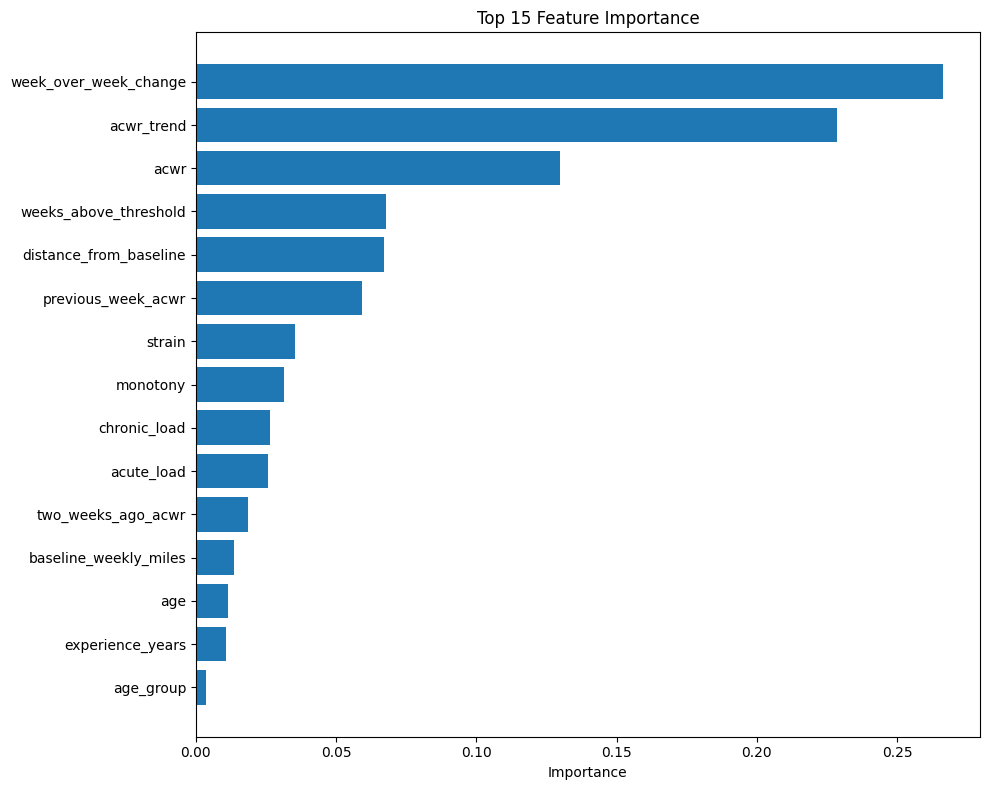


Top 15 Most Important Features:
               feature  importance
 week_over_week_change    0.266266
            acwr_trend    0.228689
                  acwr    0.129803
 weeks_above_threshold    0.067912
distance_from_baseline    0.067118
    previous_week_acwr    0.059176
                strain    0.035453
              monotony    0.031545
          chronic_load    0.026578
            acute_load    0.025593
    two_weeks_ago_acwr    0.018530
 baseline_weekly_miles    0.013554
                   age    0.011400
      experience_years    0.010831
             age_group    0.003457

✓ Validation PASSED: ACWR is in top 3 features


In [3]:
# Plot feature importance
if model is not None:
    feature_importance_df = plot_feature_importance(
        model,
        X_train_scaled.columns.tolist(),
        top_n=15,
        save_path='../outputs/feature_importance.png',
        show=True  # Display in notebook
    )
    
    print("\nTop 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Validate: ACWR should be in top 3
    top_3_features = feature_importance_df.head(3)['feature'].tolist()
    if 'acwr' in top_3_features:
        print("\n✓ Validation PASSED: ACWR is in top 3 features")
    else:
        print(f"\n⚠ Validation WARNING: ACWR is not in top 3 (top 3: {top_3_features})")
else:
    print("⚠ No model loaded - skipping feature importance analysis")

## 3. SHAP Values (Advanced Explainability)

In [4]:
# Calculate SHAP values
if model is not None:
    shap_results = calculate_shap_values(model, X_test_scaled, max_samples=100)
    
    if shap_results:
        print("✓ SHAP values calculated")
        
        # Plot SHAP summary
        plot_shap_summary(
            shap_results['shap_values'],
            shap_results['X_sample'],
            top_n=15,
            save_path='../outputs/shap_summary.png',
            show=True  # Display in notebook
        )
        
        print("\nSHAP values show how each feature contributes to predictions.")
        print("Red = increases injury risk, Blue = decreases injury risk")
    else:
        print("SHAP values not available (install with: pip install shap)")
else:
    print("⚠ No model loaded - skipping SHAP analysis")

SHAP not available. Install with: pip install shap
SHAP values not available (install with: pip install shap)


## 4. Partial Dependence Plots

✓ Saved partial dependence plot to ../outputs/partial_dependence_acwr.png


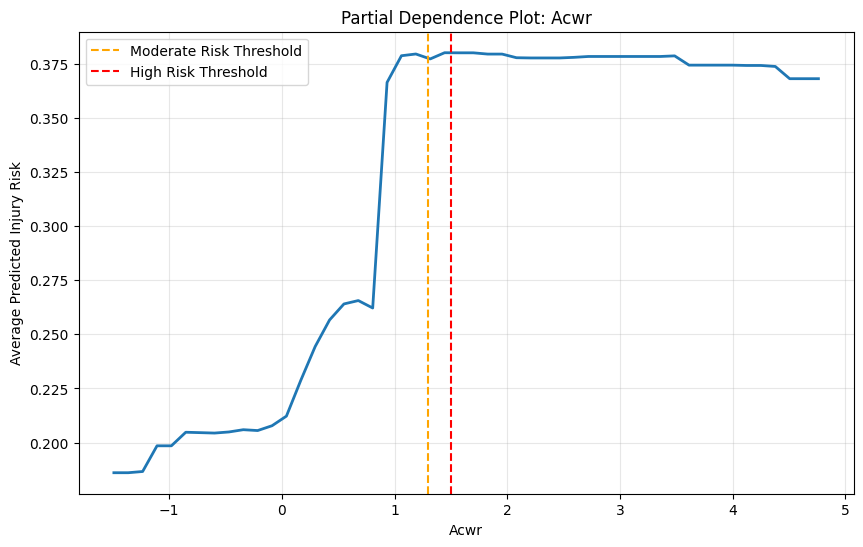

✓ Created partial dependence plot for acwr
✓ Saved partial dependence plot to ../outputs/partial_dependence_strain.png


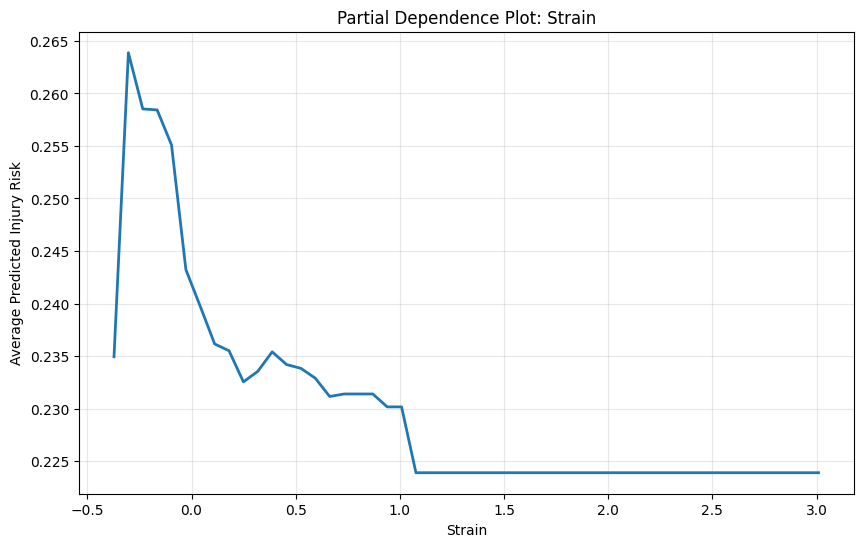

✓ Created partial dependence plot for strain
✓ Saved partial dependence plot to ../outputs/partial_dependence_week_over_week_change.png


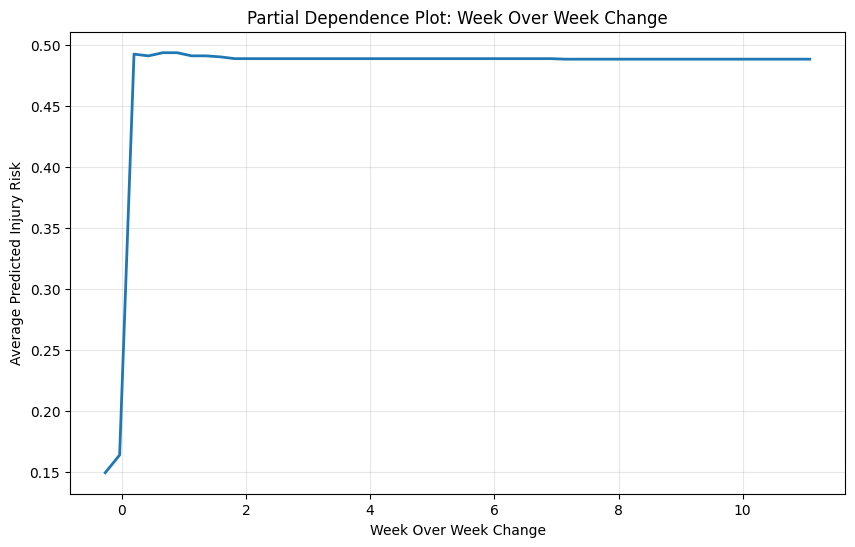

✓ Created partial dependence plot for week_over_week_change
✓ Saved partial dependence plot to ../outputs/partial_dependence_monotony.png


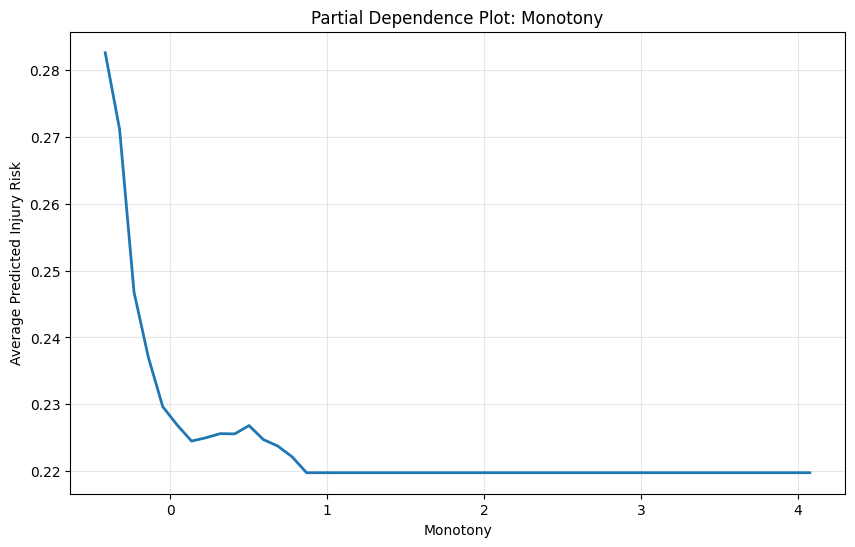

✓ Created partial dependence plot for monotony

Partial dependence plots show how injury risk changes with each feature.
For ACWR, we expect risk to increase above 1.3 and especially above 1.5.


In [5]:
# Plot partial dependence for key features
if model is not None:
    key_features = ['acwr', 'strain', 'week_over_week_change', 'monotony']
    
    for feature in key_features:
        if feature in X_test_scaled.columns:
            plot_partial_dependence(
                model,
                X_test_scaled,
                feature,
                save_path=f'../outputs/partial_dependence_{feature}.png',
                show=True  # Display in notebook
            )
            print(f"✓ Created partial dependence plot for {feature}")
    
    print("\nPartial dependence plots show how injury risk changes with each feature.")
    print("For ACWR, we expect risk to increase above 1.3 and especially above 1.5.")
else:
    print("⚠ No model loaded - skipping partial dependence plots")

## 5. Error Analysis

In [6]:
# Analyze prediction errors
if model is not None:
    y_test_pred = model.predict(X_test_scaled)
    
    error_analysis = analyze_errors(
        y_test.values,
        y_test_pred,
        X_test_scaled,
        X_test_scaled.columns.tolist()
    )
    
    print("\nError Analysis:")
    print(f"Total errors: {error_analysis['total_errors']} ({error_analysis['error_rate']:.2%})")
    print(f"False positives (false alarms): {error_analysis['false_positives']}")
    print(f"False negatives (missed injuries): {error_analysis['false_negatives']}")
    
    # Compare feature distributions
    if 'false_negative_features' in error_analysis:
        print("\nFeatures for False Negatives (missed injuries):")
        fn_features = error_analysis['false_negative_features']
        for feature in ['acwr', 'strain', 'week_over_week_change']:
            if feature in fn_features:
                print(f"  {feature}: {fn_features[feature]:.3f}")
    
    if 'false_positive_features' in error_analysis:
        print("\nFeatures for False Positives (false alarms):")
        fp_features = error_analysis['false_positive_features']
        for feature in ['acwr', 'strain', 'week_over_week_change']:
            if feature in fp_features:
                print(f"  {feature}: {fp_features[feature]:.3f}")


Error Analysis:
Total errors: 129 (17.20%)
False positives (false alarms): 106
False negatives (missed injuries): 23

Features for False Negatives (missed injuries):
  acwr: 1.086
  strain: -0.118
  week_over_week_change: 0.005

Features for False Positives (false alarms):
  acwr: 1.037
  strain: -0.131
  week_over_week_change: 0.225


## 6. Validation Against Research

In [7]:
# Validate model predictions against sports science research
if model is not None:
    # Use test set for validation
    validations = validate_against_research(
        model,
        X_test_scaled,
        X_test_scaled.columns.tolist()
    )
    
    print_validation_report(validations)
    
    # Summary
    passed = sum(1 for k, v in validations.items() if k.endswith('_threshold') or k.endswith('_spike') or k.endswith('_relationship') and v is True)
    total = sum(1 for k, v in validations.items() if k.endswith('_threshold') or k.endswith('_spike') or k.endswith('_relationship') and v is not None)
    
    print(f"\nValidation Summary: {passed}/{total} checks passed")
    if passed == total:
        print("✓ Model predictions align with sports science research!")
    else:
        print("⚠ Some validations failed - review model and features")


Model Validation Against Research

1. ACWR > 1.3 predicts higher risk: ✓ PASS
   Low ACWR risk: 0.204
   High ACWR risk: 0.708

2. ACWR > 1.5 predicts much higher risk: ✓ PASS
   Moderate ACWR risk: 0.705
   Very High ACWR risk: 0.708

3. Week-over-week spikes increase risk: ✓ PASS
   Low change risk: 0.228
   High change risk: 0.701

4. Higher strain increases risk: ✗ FAIL
   Low strain risk: 0.276
   High strain risk: 0.246



Validation Summary: 3/4 checks passed
⚠ Some validations failed - review model and features
